# Week 6: kNN

First, import your libraries!

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from matplotlib import pyplot as plt

## Data prep

Based on the following data summary, what questions and business metric should we use? 

In [2]:
bank_data = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/bank.csv")
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43628 non-null  int64 
 1   job        43628 non-null  object
 2   marital    43628 non-null  object
 3   education  43628 non-null  object
 4   default    43628 non-null  object
 5   balance    43628 non-null  int64 
 6   housing    43628 non-null  object
 7   contact    43628 non-null  object
 8   duration   43628 non-null  int64 
 9   campaign   43628 non-null  int64 
 10  pdays      43628 non-null  int64 
 11  previous   43628 non-null  int64 
 12  poutcome   43628 non-null  object
 13  signed up  43628 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 4.7+ MB


Now, let's check the composition of the data.

In [ ]:
bank_data.marital.value_counts()   # 3 levels

In [ ]:
bank_data.education.value_counts()   # 4 levels

In [ ]:
bank_data.default.value_counts()   # 2 levels

In [ ]:
bank_data.job.value_counts()   # 12 levels! What should we do?

In [ ]:
bank_data.contact.value_counts()   # 3 levels -- difference between cellular and telephone?

In [ ]:
bank_data.housing.value_counts()   # 2 levels

In [ ]:
bank_data.poutcome.value_counts()   # 4 levels

In [ ]:
bank_data['signed up'].value_counts()   # 2 levels

We should collapse the variable with 12 levels. 

In [3]:
employed = ['admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
           'self-employed', 'services', 'technician']
# unemployed = ['student', 'unemployed', 'unknown']
bank_data.job = bank_data.job.apply(lambda x: "Employed" if x in employed else "Unemployed")
bank_data.job.value_counts()

job
Employed      34001
Unemployed     9627
Name: count, dtype: int64

### What is happening above?
1. What is "employed" (variable type)? 
2. What is bank_data.job, why the .job?
3. What is .apply(lambda x: "Employed" if x in employed else "Unemployed") doing? 

Now, we convert the appropriate columns to factors.

In [4]:
# bank_data.info()   # check the variables
cat = ['job', 'marital', 'education', 'default', 'housing', 'contact',
      'poutcome', 'signed up']   # select the columns to convert
bank_data[cat] = bank_data[cat].astype('category')
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        43628 non-null  int64   
 1   job        43628 non-null  category
 2   marital    43628 non-null  category
 3   education  43628 non-null  category
 4   default    43628 non-null  category
 5   balance    43628 non-null  int64   
 6   housing    43628 non-null  category
 7   contact    43628 non-null  category
 8   duration   43628 non-null  int64   
 9   campaign   43628 non-null  int64   
 10  pdays      43628 non-null  int64   
 11  previous   43628 non-null  int64   
 12  poutcome   43628 non-null  category
 13  signed up  43628 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.3 MB


### Type out what is happening in the cell above
1. cat = [] is creating a....
2. bank_data[cat] is....
3. bank_data[cat].astype('category') is...
4. bank_data.info() helps us....

### Check for missing data

Using the seaborn package, we can see the distribution of missing values. Along the x-axis, you will see the proportion of the data missing for that variable.

In [ ]:
import seaborn as sns
sns.displot(
    data=bank_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
# plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
# the above line will same the image to your computer!

**No missing data!!**

Next, we normalize the numeric variables.

In [5]:
numeric_cols = bank_data.select_dtypes(include='int64').columns
print(numeric_cols)
# what is going to be the output?

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [6]:

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(bank_data[numeric_cols])  
scaled_df = pd.DataFrame(d, columns=numeric_cols)  
bank_data[numeric_cols] = scaled_df  

### Again type out what is happening in the chunk above
1. what is "scaler"
2. what is scaler.fit_transform doing?
3. why is (bank_data[numeric_cols])
4. What is the third line doing?
5. What is the last line doing?
6. How could we improve this code?

In [ ]:
scaler = preprocessing.MinMaxScaler()
bank_data[numeric_cols] = scaler.fit_transform(bank_data[numeric_cols])
bank_data[numeric_cols].head()
# no intermediate variables needed!

### Let's take a look at all the different objects we have created
1. Dataframe 
2. list
3. ndarray
4. Index
5. MinMaxScaler

What's the difference 

Now, we onehot encode the data -- for reference, this is the process of converting categorical variables to a usable form for a machine learning algorithm.

In [ ]:
#cat_cols = bank_data.select_dtypes(include='category').columns
#print(cat_cols)

In [ ]:
#this is for the mult-layer case, factors that have more than two levels
cat_cols = pd.Index(['marital', 'education', 'contact', 'poutcome'])

In [8]:
encoded = pd.get_dummies(bank_data[cat_cols])
encoded.head()   # note the new columns

,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,False,True,False,False,False,True,False,False,False,True,False,False,False,True
1,False,True,False,True,False,False,False,True,False,False,False,False,True,False
2,False,True,False,False,False,True,False,True,False,False,False,False,False,True
3,False,True,False,False,True,False,False,False,False,True,False,False,False,True
4,False,True,False,False,False,True,False,True,False,False,False,False,False,True


In [9]:
bank_data = bank_data.drop(cat_cols, axis=1)

In [10]:
bank_data = bank_data.join(encoded)

In [23]:
# Recode 'job' and 'default' to binary (1/0) across the DataFrame, why are we doing this? 

job_map = {'Employed': 1, 'Unemployed': 0}
default_map = {'yes': 1, 'no': 0}
housing_map = {'yes': 1, 'no': 0}

# Recode in the main dataframe
#bank_data['job'] = bank_data['job'].map(job_map).astype('int8')
#bank_data['default'] = bank_data['default'].map(default_map).astype('int8')
bank_data['housing'] = bank_data['housing'].map(housing_map).astype('int8')

In [24]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  43628 non-null  float64 
 1   job                  43628 non-null  int8    
 2   default              43628 non-null  int8    
 3   balance              43628 non-null  float64 
 4   housing              43628 non-null  int8    
 5   duration             43628 non-null  float64 
 6   campaign             43628 non-null  float64 
 7   pdays                43628 non-null  float64 
 8   previous             43628 non-null  float64 
 9   signed up            43628 non-null  category
 10  marital_divorced     43628 non-null  bool    
 11  marital_married      43628 non-null  bool    
 12  marital_single       43628 non-null  bool    
 13  education_primary    43628 non-null  bool    
 14  education_secondary  43628 non-null  bool    
 15  education_tertiary 

The data is ready! Now, let's build our model.

## Train model

We'll run the kNN algorithm on the banking data. First, we'll check the prevalence of the target class.

In [18]:
bank_data['signed up'].value_counts()[1] / bank_data['signed up'].count()

np.float64(0.11630145777940772)

This means that at random, we have an 11.6% chance of correctly picking a subscribed individual. Let's see if kNN can do any better.

In [25]:
"""
X = bank_data.drop(['signed up_1'], axis=1).values   # independent variables
y = bank_data['signed up_1'].values                  # dependent variable
"""

train, test = train_test_split(bank_data,  test_size=0.4, stratify = bank_data['signed up']) 

In [26]:
test, val = train_test_split(test, test_size=0.5, stratify=test['signed up'])

Now, let's train the classifier for k=9.

In [27]:
import random
random.seed(1984)   # kNN is a random algorithm, so we use `random.seed(x)` to make results repeatable

X_train = train.drop(['signed up'], axis=1).values
y_train = train['signed up'].values

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)

,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [28]:
# now, we check the model's accuracy on the test data:

X_test = test.drop(['signed up'], axis=1).values
y_test = test['signed up'].values

neigh.score(X_test, y_test)

0.8927343570937428

In [29]:
# now, we test the accuracy on our validation data.

X_val = val.drop(['signed up'], axis=1).values
y_val = val['signed up'].values

neigh.score(X_val, y_val)

0.8943387577355031

## Evaluate model

A 99.0% accuracy rate is pretty good but keep in mind the baserate is roughly 89/11, so we have more or less a 90% chance of guessing right if we don't know anything about the customer, but the negative outcomes we don't really care about, this models value is being able to id sign ups when they are actually sign ups. This requires us to know are true positive rate, or Sensitivity or Recall. So let's dig a little deeper.   

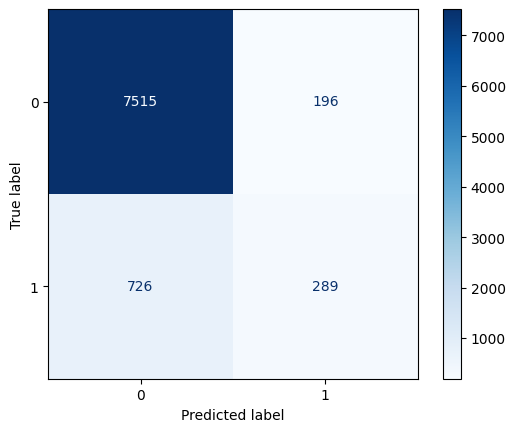

In [32]:
# create a confusion matrix using ConfusionMatrixDisplay (plot_confusion_matrix was removed)
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(neigh, X_val, y_val, cmap='Blues')
plt.show()

*tip: use this link to change the color scheme of your confusion matrix: https://matplotlib.org/stable/tutorials/colors/colormaps.html*

In [33]:
# create classification report
from sklearn.metrics import classification_report

y_val_pred = neigh.predict(X_val)

In [34]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8241
           1       0.28      0.60      0.39       485

    accuracy                           0.89      8726
   macro avg       0.63      0.75      0.66      8726
weighted avg       0.94      0.89      0.91      8726



In [35]:
# we didn't get sensitivity and specificity, so we'll calculate that ourselves.
sensitivity = 943/(943+72)   # = TP/(TP+FN)
specificity = 7707/(7707+4)   # = TN/(TN+FP)
print(sensitivity, specificity)

0.929064039408867 0.9994812605368953


#### Selecting the correct 'k'

How does "k" affect classification accuracy? Let's create a function to calculate classification accuracy based on the number of "k."

In [36]:
def chooseK(k, X_train, y_train, X_test, y_test):
    random.seed(1)
    print("calculating... ", k, "k")    # I'll include this so you can see the progress of the function as it runs
    class_knn = KNeighborsClassifier(n_neighbors=k)
    class_knn.fit(X_train, y_train)
    
    # calculate accuracy
    accu = class_knn.score(X_test, y_test)
    return accu

We'll test odd k values from 1 to 21. We want to create a table of all the data, so we'll use list comprehension to create the "accuracy" column. 

*remember: Python is end-exclusive; we want UP to 21 to we'll have to extend the end bound to include it*

In [37]:
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})

calculating...  1 k
calculating...  3 k
calculating...  5 k
calculating...  7 k
calculating...  9 k
calculating...  11 k
calculating...  13 k
calculating...  15 k
calculating...  17 k
calculating...  19 k
calculating...  21 k


In [38]:
test

,k,accu
0,1,0.860761
1,3,0.883452
2,5,0.888036
3,7,0.892620
4,9,0.892734
5,11,0.893193
6,13,0.893766
7,15,0.895256
8,17,0.894683
9,19,0.895485


In [39]:
test = test.sort_values(by=['accu'], ascending=False)
test

,k,accu
9,19,0.895485
7,15,0.895256
8,17,0.894683
10,21,0.894568
6,13,0.893766
5,11,0.893193
4,9,0.892734
3,7,0.892620
2,5,0.888036
1,3,0.883452


**From here, we see that the best value of k=1!**

Let's go through the code we wrote in a bit more detail, specifically regarding the DataFrame construction.

For reference, here's the line of code we wrote:
```
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})
```

pandas DataFrames wrap around the Python dictionary data type, which is identifiable by the use of curly brackets ({}) and key-value pairs. The keys correspond to the column names (i.e. 'k' or 'accu') while the values are a list comprised of all the values we want to include. 

For 'k', we made a list of the range of numbers from 1 to 22 (end exclusive), selecting only every *other* value. This is done using the syntax: `range(first_val, end_val, by=?)`. Having no `by=` value means that we select every value in that range.

For 'accu', we used <a href=https://www.w3schools.com/python/python_lists_comprehension.asp>list comprehension</a>, which boils down to being loop shorthand with the output being entered into a list. We could easily re-write the code as:

```
temp = []
for x in list(range(1, 22, 2)):
    temp.append(chooseK(x, X_train, y_train, X_test, y_test))
```

before adding the list to the DataFrame. Evidently, the list comprehension saves time and memory, which is why we used it earlier.

#### Now, let's graph our results!

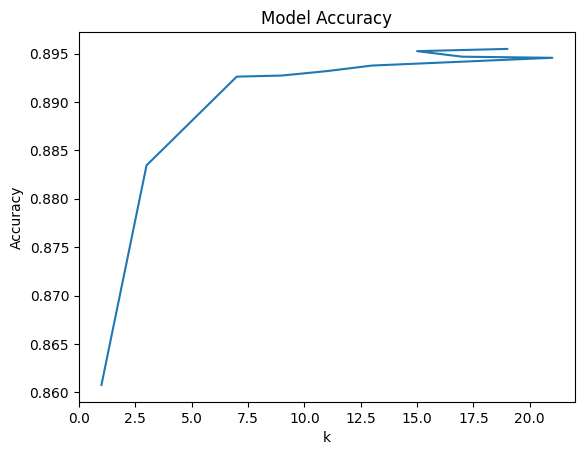

In [40]:
plt.plot(test['k'], test['accu'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

## Adjusting the threshold

In [ ]:
# we want to make a table containing: probability, expected, and actual values

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)

In [ ]:
# convert probabilities to pd df
test_probabilities = pd.DataFrame(test_probs, columns = ['not_signed_up_prob', 'signed_up_prob'])
test_probabilities

In [ ]:
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': [test_probabilities['signed_up_prob'][i] if test_preds[i]==1 else test_probabilities['not_signed_up_prob'][i] for i in range(len(test_preds))]})
# that last line is some list comprehension -- to understand that here in particular click the following link:
# https://stackoverflow.com/questions/4260280/if-else-in-a-list-comprehension

In [ ]:
final_model.head()

In [ ]:
# add a column about the probability the observation is in the positive class
final_model['pos_pred'] = [final_model.pred_prob[i] if final_model.pred_class[i]==1 else 1-final_model.pred_prob[i] for i in range(len(final_model.pred_class))]

In [ ]:
final_model.head()

In [ ]:
# convert classes to categories
final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

In [ ]:
# create probability distribution graph
import seaborn as sns

sns.displot(final_model, x="pos_pred", kind="kde")

In [ ]:
final_model.pos_pred.value_counts()

In most datasets, the probabilities range between 0 and 1, causing uncertain predictions. A threshold must be set for where you consider the prediction to actually be a part of the positive class. Is a 60% certainty positive? How about 40%? This is where you have more control over your model's classifications. **This is especially useful for reducing incorrect classifications that you may have noticed in your confusion matrix.**

In [ ]:
from sklearn.metrics import confusion_matrix

def adjust_thres(x, y, z):
    """
    x=pred_probabilities
    y=threshold
    z=tune_outcome
    """
    thres = pd.DataFrame({'new_preds': [1 if i > y else 0 for i in x]})
    thres.new_preds = thres.new_preds.astype('category')
    con_mat = confusion_matrix(z, thres)  
    print(con_mat)

In [ ]:
confusion_matrix(final_model.actual_class, final_model.pred_class)   # original model

In [ ]:
adjust_thres(final_model.pos_pred, .90, final_model.actual_class)   # raise threshold 

In [ ]:
adjust_thres(final_model.pos_pred, .3, final_model.actual_class)   # lower threshold

## More for next week: evaluation metrics

#### ROC/AUC curve
There are a few really cool graphing options, so I'll show you a few. There are several packages in Python are interactive as well!

In [ ]:
# basic graph
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, final_model.pos_pred)
auc = metrics.roc_auc_score(y_test, final_model.pos_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# installs dependency for next graph
! pip install plot_metric

In [ ]:
# a pretty cool one

from plot_metric.functions import BinaryClassification

# Visualisation with plot_metric
bc = BinaryClassification(y_test, final_model.pred_class, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

#### F1 score

In [ ]:
metrics.f1_score(y_test, final_model.pred_class)

#### LogLoss

In [ ]:
metrics.log_loss(y_test, final_model.pred_class)

## Another quick example

In [ ]:
from pydataset import data

iris = data("iris")
iris.info()

In [ ]:
iris.describe()

In [ ]:
from sklearn.preprocessing import scale

cols = list(iris.columns[:4])

scaledIris = pd.DataFrame(scale(iris.iloc[:, :4]), index=iris.index, columns=cols)

In [ ]:
scaledIris.info()

In [ ]:
scaledIris['Species'] = iris['Species']

In [ ]:
# split datasets
irisTrain, irisTest = train_test_split(scaledIris,  test_size=0.4, stratify = scaledIris['Species']) 
irisTest, irisVal = train_test_split(irisTest, test_size=0.5, stratify = irisTest['Species'])

In [ ]:
Xi_train = irisTrain.drop(['Species'], axis=1)
yi_train = irisTrain['Species']

Xi_test = irisTest.drop(['Species'], axis=1)
yi_test = irisTest['Species']

Xi_val = irisVal.drop(['Species'], axis=1)
yi_val = irisVal['Species']

In [ ]:
iris_neigh = KNeighborsClassifier(n_neighbors=3)
iris_neigh.fit(Xi_train, yi_train)

In [ ]:
iris_neigh.score(Xi_test, yi_test)

In [ ]:
iris_neigh.score(Xi_val, yi_val)

In [ ]:
plot_confusion_matrix(iris_neigh, Xi_val, yi_val, cmap='Blues')  
plt.show()

## Example using 10-k cross-validation 

In [ ]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=12) 

X_si = scaledIris.drop(['Species'], axis=1)
y_si = scaledIris['Species']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

cv_neigh = KNeighborsClassifier(n_neighbors=3)   # create classifier
scores = cross_val_score(cv_neigh, X_si, y_si, scoring='accuracy', cv=rkf, n_jobs=-1)   # do repeated cv

print('Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

In [ ]:
plt.plot(scores)

In [ ]:
# more complex version so you can create a graph for testing and training accuracy (not built into the previous version)

#Split arrays or matrices into train and test subsets
Xsi_train, Xsi_test, ysi_train, ysi_test = train_test_split(X_si, y_si, test_size=0.20) 
rcv_knn = KNeighborsClassifier(n_neighbors=6)
rcv_knn.fit(Xsi_train, ysi_train)

print("Preliminary model score:")
print(rcv_knn.score(Xsi_test, ysi_test))

no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    rcv_knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    rcv_knn.fit(Xsi_train, ysi_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = rcv_knn.score(Xsi_train, ysi_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = rcv_knn.score(Xsi_test, ysi_test)

# Visualization of k values vs accuracy
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Variable importance

There is no easy way in SKLearn to calculate variable importance for a KNN model. So, we'll use a slightly hacked-together solution.

Variable importance reflects the significance one variable has on the model. If a variable is more important, that variable being removed/permuted has a larger effect on the output of the model. So, if we check the changes such permutations have, we should be able to extract the feature importance.

In [ ]:
data = {'sepal_length': [0], 'sepal_width': [0], 'petal_length': [0], 'petal_width': [0]}
feat_imp = pd.DataFrame(data)
feat_imp.head()

In [ ]:
# baseline

fin_knn = KNeighborsClassifier(n_neighbors=7)
fin_knn.fit(Xsi_train, ysi_train)

print(fin_knn.score(Xsi_test, ysi_test))
plot_confusion_matrix(fin_knn, Xsi_test, ysi_test, cmap='Blues')  

#### change `Sepal.Length`

In [ ]:
Xsi_test.head()

In [ ]:
perm_SL = Xsi_test.copy()   # # copy df; we don't want to alter the actual data
perm_SL['Sepal.Length'] = np.random.permutation(perm_SL['Sepal.Length'])   # permute data
perm_SL.head()

In [ ]:
fin_knn.score(perm_SL, ysi_test)

In [ ]:
feat_imp['sepal_length'] = fin_knn.score(Xsi_test, ysi_test) - fin_knn.score(perm_SL, ysi_test)
feat_imp.head()

In [ ]:
plot_confusion_matrix(fin_knn, perm_SL, ysi_test, cmap='Blues')  # what got misclassified?

Instead of making this repetitive, we can turn this into a function and loop.

In [ ]:
def featureImportance(X, y, model):
    # create dataframe of variables
    var_imp = pd.DataFrame(columns=list(X.columns))
    var_imp.loc[0] = 0
    base_score = model.score(X, y)
    for col in list(X.columns):
        temp = X.copy()   # # copy df; we don't want to alter the actual data
        temp[col] = np.random.permutation(temp[col])   # permute data
        var_imp[col] = base_score - model.score(temp, y)
        # plot_confusion_matrix(model, temp, y, cmap='Blues')  # what got misclassified?
    print(var_imp)

In [ ]:
featureImportance(Xsi_test, ysi_test, fin_knn)

From here, we find the important variables!

### General eval

In [ ]:
plot_confusion_matrix(fin_knn, Xsi_test, ysi_test, cmap='Blues')  

Looks like we only misclassified one virginica as versicolor. Let's see how certain our predictions were.

In [ ]:
iris2_probs = fin_knn.predict_proba(Xsi_test)
iris2_probs